In [2]:
using System.Threading;
using System.Collections.Concurrent;
using System.Diagnostics;
using Microsoft.DotNet.Interactive.Formatting;
#r "nuget:ScottPlot, 5.0.36"

BlockingCollection<string> queue1 = new BlockingCollection<string>();
ConcurrentQueue <string> queue2 = new ConcurrentQueue<string>();
Queue<string> queue3 = new Queue<string>();

Stopwatch timer = new Stopwatch();
Stopwatch timer1 = new Stopwatch();

static Semaphore semaphore = new Semaphore(0,2);


Installed Packages ScottPlot, 5.0.36

Loading extensions from `C:\Users\jarz0\.nuget\packages\skiasharp\2.88.8\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

Среднее время на чтение-запись BlockingCollection коллекции за 10 итераций = 653.4 мc
Среднее время на запись BlockingCollection коллекции за 10 итераций = 339.8 мc
Среднее время на чтение BlockingCollection коллекции за 10 итераций = 339.8 мc



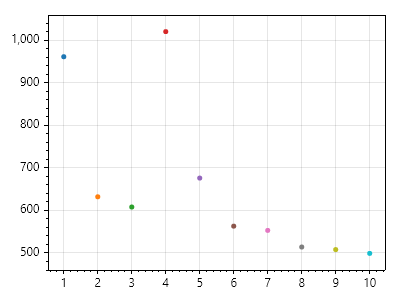

In [3]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => 
    w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);
ScottPlot.Plot plot = new();

List<long> times = new List<long>();
List<long> readtimes = new List<long>();
List<long> writetimes = new List<long>();

for(int iteration=0;iteration<10;iteration++)
{
    Thread thr = new (() =>
    {
        semaphore.WaitOne();
        timer.Restart();
        for(int i =0;i<1e6;i++)
        {
            queue1.Add("abc123");
        }
        timer.Stop();
    });

    Thread thr1 = new (() =>
    {
        semaphore.WaitOne();
        timer1.Restart();
        for(int i =0;i<1e6;i++)
        {
            var v = queue1.Take();
        }
        timer1.Stop();
    });

    thr.Start();
    thr1.Start();
    semaphore.Release(2);

    thr.Join();
    thr1.Join();

    var totaltime = timer.ElapsedMilliseconds + timer1.ElapsedMilliseconds;

    times.Add(totaltime);
    writetimes.Add(timer1.ElapsedMilliseconds);
    readtimes.Add(timer1.ElapsedMilliseconds);

    plot.Add.Scatter(iteration+1, totaltime);
}

double sum = 0;
List<string[]> sums = new List<string[]>();
foreach(var v in times)
    sum+=v;
sum/=times.Count;
sums.Add(new string[] {"BlockingCollection", $"{Convert.ToString(sum)}"});
Console.WriteLine($"Среднее время на чтение-запись BlockingCollection коллекции за 10 итераций = {sum} мc");
sum=0;
foreach(var v in writetimes)
    sum+=v;
sum/=writetimes.Count;
Console.WriteLine($"Среднее время на запись BlockingCollection коллекции за 10 итераций = {sum} мc");
sum=0;
foreach(var v in readtimes)
    sum+=v;
sum/=readtimes.Count;
Console.WriteLine($"Среднее время на чтение BlockingCollection коллекции за 10 итераций = {sum} мc");

plot



Среднее время на чтение-запись ConcurrentQueue коллекции за 10 итераций = 59.3 мc
Среднее время на запись ConcurrentQueue коллекции за 10 итераций = 32.2 мc
Среднее время на чтение ConcurrentQueue коллекции за 10 итераций = 32.2 мc



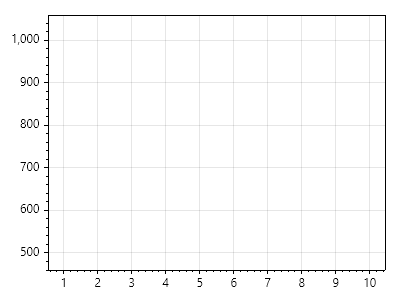

In [4]:
plot.Clear();
times.Clear();
readtimes.Clear();
writetimes.Clear();

for(int iteration=0;iteration<10;iteration++)
{
    Thread thr = new (() =>
    {
        semaphore.WaitOne();
        timer.Restart();
        for(int i =0;i<1e6;i++)
        {
            queue2.Enqueue("abc123");
        }
        timer.Stop();
    });

    Thread thr1 = new (() =>
    {
        semaphore.WaitOne();
        timer1.Restart();
        for(int i =0;i<1e6;i++)
        {
            var v = "abc123";
            queue2.TryDequeue(out v);
        }
        timer1.Stop();
    });

    thr.Start();
    thr1.Start();
    semaphore.Release(2);

    thr.Join();
    thr1.Join();

    var totaltime = timer.ElapsedMilliseconds + timer1.ElapsedMilliseconds;
    times.Add(totaltime);
    writetimes.Add(timer1.ElapsedMilliseconds);
    readtimes.Add(timer1.ElapsedMilliseconds);

    plot.Add.Scatter(iteration+1, totaltime);
}

double sum = 0;
foreach(var v in times)
    sum+=v;
sum/=times.Count;
sums.Add(new string[] {"ConcurrentQueue", $"{Convert.ToString(sum)}"});
Console.WriteLine($"Среднее время на чтение-запись ConcurrentQueue коллекции за 10 итераций = {sum} мc");
sum=0;
foreach(var v in writetimes)
    sum+=v;
sum/=writetimes.Count;
Console.WriteLine($"Среднее время на запись ConcurrentQueue коллекции за 10 итераций = {sum} мc");
sum=0;
foreach(var v in readtimes)
    sum+=v;
sum/=readtimes.Count;
Console.WriteLine($"Среднее время на чтение ConcurrentQueue коллекции за 10 итераций = {sum} мc");

plot



Среднее время на чтение-запись Queue коллекции за 10 итераций с синхронизацией потоков = 36.925599999999996 c
Среднее время на запись Queue коллекции за 10 итераций = 18.462799999999998 c
Среднее время на чтение Queue коллекции за 10 итераций = 18.462799999999998 c



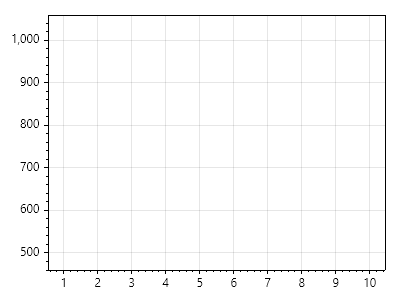

In [5]:
static AutoResetEvent thrsig = new AutoResetEvent(false);
static AutoResetEvent thr1sig = new AutoResetEvent(true);

plot.Clear();
times.Clear();
readtimes.Clear();
writetimes.Clear();

for(int iteration=0;iteration<10;iteration++)
{
    Thread thr = new (() =>
    {
        semaphore.WaitOne();
        timer.Restart();
        for(int i =0;i<1e6;i++)
        {
            thr1sig.WaitOne();
            queue3.Enqueue("abc123");
            thrsig.Set();
        }
        timer.Stop();
    });

    Thread thr1 = new (() =>
    {
        semaphore.WaitOne();
        timer1.Restart();
        for(int i =0;i<1e6;i++)
        {
            thrsig.WaitOne();
            var v = queue3.Dequeue();
            thr1sig.Set();
        }
        timer1.Stop();
    });

    thr.Start();
    thr1.Start();
    semaphore.Release(2);

    thr.Join();
    thr1.Join();

    var totaltime = timer.ElapsedMilliseconds + timer1.ElapsedMilliseconds;
    times.Add(totaltime);
    writetimes.Add(timer1.ElapsedMilliseconds);
    readtimes.Add(timer1.ElapsedMilliseconds);

    plot.Add.Scatter(iteration+1, totaltime/1000);
}

double sum = 0;
foreach(var v in times)
    sum+=v;
sum/=times.Count;
sums.Add(new string[] {"Queue", $"{Convert.ToString(sum)}"});
Console.WriteLine($"Среднее время на чтение-запись Queue коллекции за 10 итераций с синхронизацией потоков = {sum/1000} c");
sum=0;
foreach(var v in writetimes)
    sum+=v;
sum/=writetimes.Count;
Console.WriteLine($"Среднее время на запись Queue коллекции за 10 итераций = {sum/1000} c");
sum=0;
foreach(var v in readtimes)
    sum+=v;
sum/=readtimes.Count;
Console.WriteLine($"Среднее время на чтение Queue коллекции за 10 итераций = {sum/1000} c");

plot



In [42]:
sums = sums.OrderBy(x => Convert.ToDouble(x[1])).ToList();
Console.WriteLine($"Наиболее эффективная коллекция по времени работы - {sums[0][0]} с временем работы = {sums[0][1]} мс");
Console.WriteLine($"Разница в быстродействии составляет: {Math.Round((Convert.ToDouble(sums[sums.Count-1][1])/Convert.ToDouble(sums[0][1]) - 1) *100)} %");

Наиболее эффективная коллекция по времени работы - ConcurrentQueue с временем работы = 59.3 мс
Разница в быстродействии составляет: 62169 %
